In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

In [2]:
def read_image(data,label,filepath):
    for i in range(2):
        path = os.path.join(filepath,str(i))
        images = os.listdir(path)
        for a in images:
            try:
                image = cv2.imread(path + '/'+ a)
                data.append(image)
                label.append(i)
            except Exception as e:
                print(e)

In [3]:
train_path ='''cat_dog/train'''
test_path = '''cat_dog/test'''
X_train = []
X_test = []
y_train = []
y_test = []

read_image(X_train,y_train,train_path)
read_image(X_test,y_test,test_path)

In [4]:
def preprocess_img(data):
    X = []
    for i in data:
        image = cv2.resize(i,(250,250),interpolation = cv2.INTER_AREA)
        X.append(image)
    X = np.array(X)
    return X

x_train = preprocess_img(X_train)
x_test = preprocess_img(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [5]:
x_train.shape

(557, 250, 250, 3)

In [5]:
img_rows, img_cols, channels = 250, 250, 3
num_classes = 2

x_train = x_train / 255
x_test = x_test / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (140, 250, 250, 3) (140, 2) (557, 250, 250, 3) (557, 2)


In [6]:
labels = ['cat','dog']

In [7]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [11]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(x_test, y_test))

Epoch 1/30
18/18 [==============================] - 6s 227ms/step - loss: 0.2627 - accuracy: 0.4883 - val_loss: 0.2491 - val_accuracy: 0.5857
Epoch 2/30
18/18 [==============================] - 2s 138ms/step - loss: 0.2492 - accuracy: 0.5135 - val_loss: 0.2486 - val_accuracy: 0.5500
Epoch 3/30
18/18 [==============================] - 2s 137ms/step - loss: 0.2438 - accuracy: 0.5853 - val_loss: 0.2469 - val_accuracy: 0.5357
Epoch 4/30
18/18 [==============================] - 2s 131ms/step - loss: 0.2363 - accuracy: 0.6104 - val_loss: 0.2462 - val_accuracy: 0.5714
Epoch 5/30
18/18 [==============================] - 2s 119ms/step - loss: 0.2377 - accuracy: 0.5925 - val_loss: 0.2436 - val_accuracy: 0.6286
Epoch 6/30
18/18 [==============================] - 2s 104ms/step - loss: 0.2233 - accuracy: 0.6320 - val_loss: 0.2472 - val_accuracy: 0.6214
Epoch 7/30
18/18 [==============================] - 2s 105ms/step - loss: 0.2142 - accuracy: 0.6715 - val_loss: 0.2468 - val_accuracy: 0.6286
Epoch 

In [12]:
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.32803550362586975, 0.6357142925262451]


In [13]:
model.save('cat_dog.h5')

In [8]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [31]:
def save_attacked_image(x_train, y_train):
    index = 0
    for image, label in zip(x_train, y_train):
        perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
        adversarial = image + perturbations * 0.01
        cv2.imwrite('attacked/' + str(index) + '.png', adversarial[0] * 255)
        # cv2.imwrite('original/' + str(index) + '_original.png', image*255)
        index = index + 1

In [30]:
save_attacked_image(x_train, y_train)

In [15]:
image = x_train[0]
image_label = y_train[0]

In [16]:
image_label

array([1., 0.], dtype=float32)

In [17]:
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


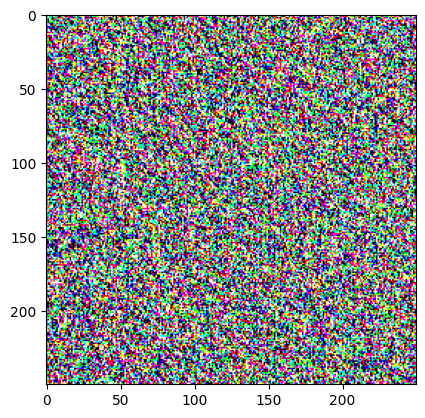

In [18]:
plt.imshow(perturbations.reshape(img_rows, img_cols, channels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


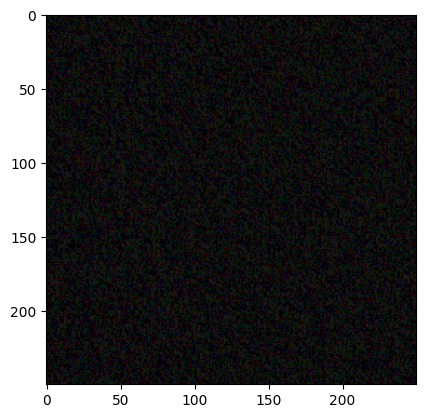

In [19]:
sample = perturbations * 0.1
plt.imshow(sample.reshape(img_rows, img_cols, channels))

In [20]:
adversarial = image + perturbations * 0.01

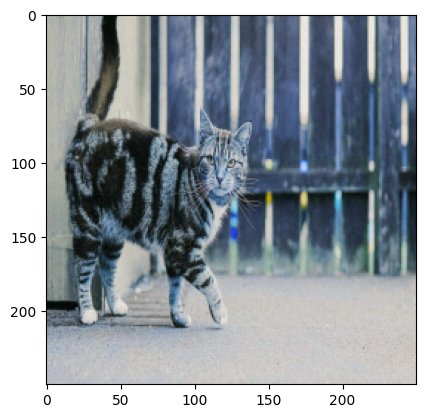

In [21]:
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

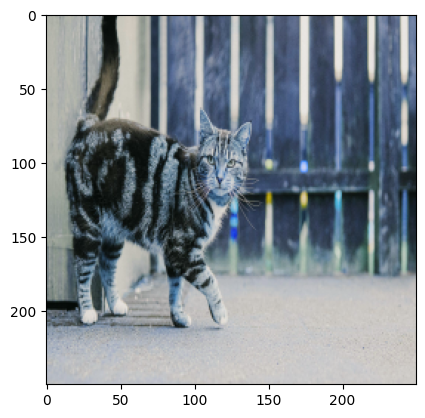

In [22]:
plt.imshow(image.reshape((img_rows, img_cols, channels)))

In [23]:
print(model.predict(adversarial))
print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])

1/1 [==============================] - 1s 643ms/step
[[0.31128225 0.6887177 ]]
1/1 [==============================] - 0s 33ms/step
cat


: 